# HA1 - Cats and dogs

<img src="http://lghttp.32478.nexcesscdn.net/80E972/organiclifestylemagazine/wp-content/uploads/2015/10/Cats-and-Dogs.jpg" alt="Cats and dogs" style="width: 5000px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It comprises of 25k colored images of dogs and cats. Our goal with this dataset will be to create a classifier that can tell us if the input image is of a cat or a dog.

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance.

Tips:
- If you get errors saying you've exhausted the GPU resources, well, then you exhausted the GPU resources ;). However, sometimes that's because TensorFlow didn't release a part of the GPU's memory. If you think your CNN should fit in your memory during training, try restarting the kernel and directly training only that architecture.
- Every group has enough credits on google cloud to complete this assignment. However, this statement assumes you'll use your resources judiciously (e.g. always try the code first in your machine and make sure everything works properly before starting your instances) and **won't forget to stop your instance after using it,**  otherwise you might run out of credits.
- Before starting, take a look at the images we'll be using. This is a hard task, don't get discouraged if your first models perform poorly (several participants in the original competition didn't achieve an accuracy higher than 60%).

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [1]:
# Building the model
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input

# One-hot encoding
from keras.utils import np_utils

# Callbacks for training
from keras.callbacks import TensorBoard, EarlyStopping

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Ndarray computations
import numpy as np 

#loading imaged from directory
from keras.preprocessing.image import ImageDataGenerator as idg
from keras.preprocessing.image import load_img, img_to_array

#loading optimizer 
from keras.optimizers import Adam

#Callbakcs
from keras.callbacks import TensorBoard, EarlyStopping

#Os module
import os

#Pandas
import pandas as pd

Using TensorFlow backend.


---
## 1. Loading the data and preprocessing

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats) and download the data from there. You should download both the `train.zip` and `test.zip` files. The split ratio between training and validation has not been made, you'll need to do it yourself. The `test.zip` file contains unlabeled data, so that participants in the contest are not able to train on this set.

As mentioned in CL3, for this assignment you should use [data generators](https://keras.io/preprocessing/image/) to load the images to your CPU/GPU memory. Because of this, your folder structure for the data should conform to the folder structure expected by the data generators (i.e. the samples should be separated into one folder for each class). Furthermore, we ask you to first start with a smaller subset of the data (1/5 of the number of samples), in order to test different models faster.

This means that you should create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      Cats        Dogs       Cats        Dogs       Cats        Dogs       Cats        Dogs

The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`. We provide you a notebook that shows how to achieve this, starting from the original `train` folder extracted from `train.zip`. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

Although we specifically guide you to use 1/5 of the data in the smaller dataset, you should decide how to split the validation data. Please specify your splits in the following cells.

** ------------------  Smaller subset ------------------ **

** % Samples in the training set:** 3500

** % Samples in the validation set:** 1500

** ------------------  Entire dataset ------------------ **

** % Samples in the training set:** 20000

** % Samples in the validation set:** 5000

---
Once you have the expected folder structure, create two data generators for automatically generating batches from the images in your smaller subset of data. Don't use any [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/), but feel free to preprocess the data as you see fit. After instantiating them, run the `flow_from_directory` method with the desired arguments.

Hints:
- The specified `batch_size` should be chosen so that your don't run out of memory.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. If so, take a look at the argument `target_size` for the `flow_from_directory` method of data generators.
- Resizing the images to a smaller size while loading them can be beneficial.

In [2]:
# Normalize input data
test_data_gen = idg(rescale=1./255)
val_data_gen = idg(rescale=1./255)

# Set Class
cls=['dogs','cats']

# Target size
size_w=128
size_h=128

# Batch size
batchSize=32

# Number of steps per epoch based on small sets
trainStepEpoch = 3500//batchSize
valStepEpoch = 1500//batchSize

# Setup ImageDataGenerators for validation and train
val_batch=val_data_gen.flow_from_directory('small_val',
                        target_size=(size_h, size_w),
                        batch_size=batchSize,
                        classes=cls)
train_batch=test_data_gen.flow_from_directory('small_train',
                        target_size=(size_h, size_w),
                        batch_size=batchSize,
                        classes=cls)

Found 1500 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


---
## 2. Training

Create your first CNN architecture for this task. Start with something as simple as possible, that you're almost sure can get an accuracy better than 50% (we'll improve upon it later).

Tip:
- If Tensorflow is your backend, your `input_shape` is always `(img_width, img_height, 3)` (i.e. channels **last**)

In [3]:
# Define initial model
def base_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(size_h, size_w, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # Compile model
    model.compile(Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train your model using the `fit_generator` method and the two data generators you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

In [4]:
# Call model
myModel=base_model()

#Setup callbacks
tb=TensorBoard(log_dir='./logs/op1')
estop = EarlyStopping(monitor='val_acc', patience=5)

#train the model
model_out_1 = myModel.fit_generator(generator=train_batch, 
                      steps_per_epoch=trainStepEpoch,
                      validation_data=val_batch,
                      validation_steps=valStepEpoch, 
                      epochs=10,
                      callbacks=[tb,estop])
# Save model
myModel.save('Model_1.h5')

Epoch 1/10
109/109 [==============================] - 14s - loss: 0.8584 - acc: 0.5350 - val_loss: 0.6521 - val_acc: 0.5870
Epoch 2/10
109/109 [==============================] - 13s - loss: 0.5684 - acc: 0.7119 - val_loss: 0.6025 - val_acc: 0.6814
Epoch 3/10
109/109 [==============================] - 13s - loss: 0.3887 - acc: 0.8370 - val_loss: 0.5961 - val_acc: 0.6957
Epoch 4/10
109/109 [==============================] - 13s - loss: 0.2376 - acc: 0.9172 - val_loss: 0.6696 - val_acc: 0.6773
Epoch 5/10
109/109 [==============================] - 13s - loss: 0.1367 - acc: 0.9656 - val_loss: 0.8813 - val_acc: 0.6821
Epoch 6/10
109/109 [==============================] - 13s - loss: 0.0787 - acc: 0.9819 - val_loss: 0.9538 - val_acc: 0.6827
Epoch 7/10
109/109 [==============================] - 13s - loss: 0.0342 - acc: 0.9968 - val_loss: 1.0537 - val_acc: 0.6936
Epoch 8/10
109/109 [==============================] - 13s - loss: 0.0153 - acc: 0.9991 - val_loss: 1.1542 - val_acc: 0.6909
Epoch 9/

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Hint:
- The `fit_generator` method returns a `history` object.

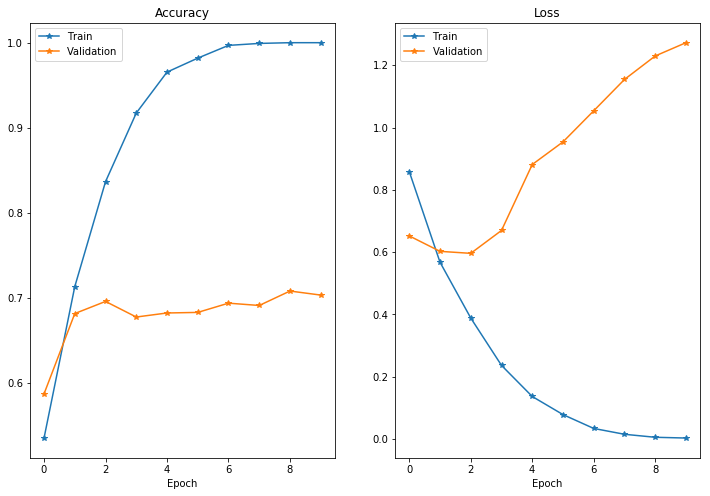

In [5]:
# Setup figure with axes
f, ax = plt.subplots(1,2,figsize=[12,8])

ax[0].plot(model_out_1.history['acc'],'*-')
ax[0].plot(model_out_1.history['val_acc'],'*-')
ax[0].legend(['Train','Validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_title('Accuracy')

# Plot loss of train and validation
ax[1].plot(model_out_1.history['loss'],'*-')
ax[1].plot(model_out_1.history['val_loss'],'*-')
ax[1].legend(['Train','Validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss')

Based on these, what would you suggest for improving your model? Why?

**Your answer**: Based on these plots one can see that the accuracy for the training set continues to grow while the accuracy of the validation set stagnates. This mean that the varaince is increasing and we are overfitting our model. This can also be verified in the loss plot where the loss of the validaton set start to grows. According to the "recipe of machine learning" this model needs to be trained with more data. But since we only train on the small data set we'll try more layers instead.

---
## 3. Improving your initial model

Improve your initial model according to you answer above. Write the new definition in the cell below and train it.

In [6]:
# Define improved model
def second_model():
    # create model
    model = Sequential()
    model.add(Conv2D(128, (3, 3), input_shape=(size_h, size_w, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), input_shape=(size_h, size_w, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # Compile model
    model.compile(Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Call model
myModel=second_model()

#Setup callbacks
tb=TensorBoard(log_dir='./logs/op2')
estop = EarlyStopping(monitor='val_acc', patience=3)

# Train model
model_out_2 = myModel.fit_generator(generator=train_batch, 
                      steps_per_epoch=trainStepEpoch,
                      validation_data=val_batch,
                      validation_steps=valStepEpoch, 
                      epochs=15,
                      callbacks=[tb,estop])

Epoch 1/15
109/109 [==============================] - 18s - loss: 0.7023 - acc: 0.5493 - val_loss: 0.6859 - val_acc: 0.5312
Epoch 2/15
109/109 [==============================] - 18s - loss: 0.6539 - acc: 0.5992 - val_loss: 0.6575 - val_acc: 0.6386
Epoch 3/15
109/109 [==============================] - 17s - loss: 0.5813 - acc: 0.6954 - val_loss: 0.5977 - val_acc: 0.6827
Epoch 4/15
109/109 [==============================] - 18s - loss: 0.4629 - acc: 0.7772 - val_loss: 0.6357 - val_acc: 0.6943
Epoch 5/15
109/109 [==============================] - 17s - loss: 0.3399 - acc: 0.8554 - val_loss: 0.6270 - val_acc: 0.7167
Epoch 6/15
109/109 [==============================] - 17s - loss: 0.2272 - acc: 0.9135 - val_loss: 0.7531 - val_acc: 0.6990
Epoch 7/15
109/109 [==============================] - 18s - loss: 0.1182 - acc: 0.9621 - val_loss: 0.8966 - val_acc: 0.7188
Epoch 8/15
109/109 [==============================] - 18s - loss: 0.0562 - acc: 0.9840 - val_loss: 1.1730 - val_acc: 0.7181
Epoch 9/

Plot the accuracy in the test and validation set, using the initial model and your newly improved one.

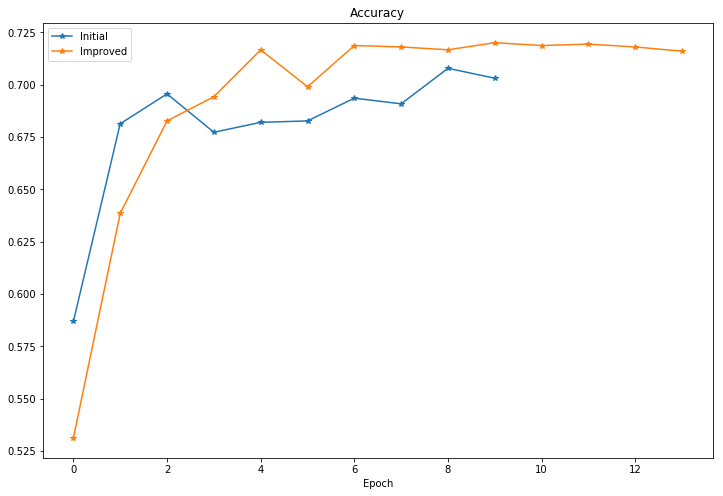

In [7]:
# Setup figure axes and plot validation accuracy comparing initial and improved model
f, ax = plt.subplots(1,1,figsize=[12,8])
ax.plot(model_out_1.history['val_acc'],'*-')
ax.plot(model_out_2.history['val_acc'],'*-')
ax.legend(['Initial','Improved'])
ax.set_xlabel('Epoch')
ax.set_title('Accuracy')

Did your results improve? Explain why, or why not.

**Your answer**: As can be seen in the plot there is a small improvement in the model which can be described as in the previous task, where we need more data. One other option could be to try an even larger network with different architectures like changing, learning rate, lossfunction, activation functions etc.

---
## 4. Obtaining the *best* model

Continue to improve your model architecture by comparing the value of the metrics you're interested in both the training and validation set. Try different ideas, and consider comparing them using tensorboard. When you're happy with one architecture, copy it in the cell below and train it here. Save the optimization history (i.e. the `history` object returned by the `fit_generator`). You'll use this later to compare your best model with the one using transfer learning.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to ping-pong, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [9]:
def third_model():
    # create model
    model = Sequential()
    model.add(Conv2D(128, (3, 3), input_shape=(size_h, size_w, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), input_shape=(size_h, size_w, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), input_shape=(size_h, size_w, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), input_shape=(size_h, size_w, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # Compile model
    model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Call model
myModel = third_model()

#Setup callbacks
tb=TensorBoard(log_dir='./logs/op3')
estop = EarlyStopping(monitor='val_acc', patience=3)

#train the model
model_out_3 = myModel.fit_generator(generator=train_batch, 
                      steps_per_epoch=trainStepEpoch,
                      validation_data=val_batch,
                      validation_steps=valStepEpoch, 
                      epochs=20,
                      callbacks=[tb,estop])

Epoch 1/20
109/109 [==============================] - 49s - loss: 0.6729 - acc: 0.5626 - val_loss: 0.6430 - val_acc: 0.6444
Epoch 2/20
109/109 [==============================] - 49s - loss: 0.6195 - acc: 0.6495 - val_loss: 0.5927 - val_acc: 0.6832
Epoch 3/20
109/109 [==============================] - 49s - loss: 0.5504 - acc: 0.7251 - val_loss: 0.6063 - val_acc: 0.6635
Epoch 4/20
109/109 [==============================] - 49s - loss: 0.5163 - acc: 0.7517 - val_loss: 0.5460 - val_acc: 0.7255
Epoch 5/20
109/109 [==============================] - 49s - loss: 0.4594 - acc: 0.7731 - val_loss: 0.5349 - val_acc: 0.7384
Epoch 6/20
109/109 [==============================] - 49s - loss: 0.4078 - acc: 0.8187 - val_loss: 0.6503 - val_acc: 0.7030
Epoch 7/20
109/109 [==============================] - 49s - loss: 0.3744 - acc: 0.8331 - val_loss: 0.5794 - val_acc: 0.7132
Epoch 8/20
109/109 [==============================] - 49s - loss: 0.3111 - acc: 0.8743 - val_loss: 0.5623 - val_acc: 0.7500
Epoch 9/

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

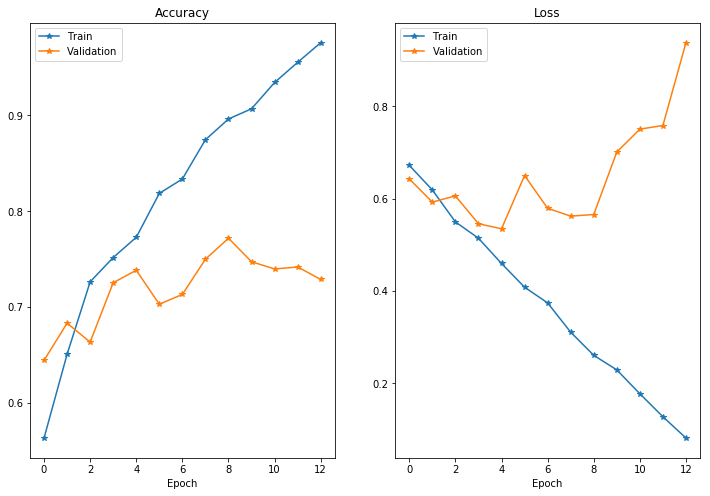

In [10]:
# Setup figure axes
f, ax = plt.subplots(1,2,figsize=[12,8])

# Plot accuracy of train and validation
ax[0].plot(model_out_3.history['acc'],'*-')
ax[0].plot(model_out_3.history['val_acc'],'*-')
ax[0].legend(['Train','Validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_title('Accuracy')

# Plot loss of train and validation
ax[1].plot(model_out_3.history['loss'],'*-')
ax[1].plot(model_out_3.history['val_loss'],'*-')
ax[1].legend(['Train','Validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss')

[Save your model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) to disk as a HDF5 file (the architecture, weights and optimizer state). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual `.h5` files you create are not relevant to your ping-pong submission.

In [11]:
myModel.save('Model_3.h5')

---
## 5. Transfer Learning

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected + classification layers). We'll substitute them with a single fully connected layer, and a classification layer that makes sense for our problem.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the VGG16 model without the top layers, from the `applications` submodule from Keras. Make sure to also load the weights obtained from the ImageNet pretraining.

In [12]:
# Load pretrained VGG16 net without top layers
vgg16 = VGG16(include_top=None, weights='imagenet',input_shape = (size_h,size_w,3))

Create a new model with the layers you want to add on top of VGG. The kernels and bias in these layers should be initialized randomly.

In [13]:
# Create top layers
x = vgg16.get_layer('block5_conv3').output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x)

Now add the new model on top of VGG.

Tip:
- The VGG model you loaded from the `applications` submodule is from the [`Model`](https://keras.io/models/model/) class, not the `Sequential` class, so it doesn't have some methods you're used to (like `add`, for instance). It might be helpful to read [this introduction to the Model class](https://keras.io/getting-started/functional-api-guide/).

In [14]:
# Merge VGG with top layers
model_final = Model(inputs=vgg16.input, outputs=x)

### 5.1 Using VGG features

Now we're almost ready to train the new model. However, since the top layers of this architecture are being initialized randomly, it's sometimes possible for them to generate large gradients that can wreck the pretraining of the bottom layers. To avoid this, freeze all the VGG layers in your architecture (i.e. signal to the optimizer that these should not be changed during optimization) by setting the `trainable` attribute of them to `False`.

In [15]:
# Freeze bottom layers
for layer in vgg16.layers:
    layer.trainable = False

Create the callbacks (if any) you would like to use for this training here.

In [16]:
# Setup callbacks
tb=TensorBoard(log_dir='./logs/op4')
estop = EarlyStopping(monitor='val_acc', patience=3)

Compile the model and train it.

In [17]:
# Compile model
model_final.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
model_out_4 = model_final.fit_generator(generator=train_batch, 
                      steps_per_epoch=trainStepEpoch,
                      validation_data=val_batch,
                      validation_steps=valStepEpoch, 
                      epochs=20,
                      callbacks=[tb,estop])
# Save model
model_final.save('Model_4.h5')

Epoch 1/20
109/109 [==============================] - 40s - loss: 0.6017 - acc: 0.7364 - val_loss: 0.5164 - val_acc: 0.7875
Epoch 2/20
109/109 [==============================] - 37s - loss: 0.4733 - acc: 0.8077 - val_loss: 0.4279 - val_acc: 0.8324
Epoch 3/20
109/109 [==============================] - 37s - loss: 0.4082 - acc: 0.8289 - val_loss: 0.3911 - val_acc: 0.8399
Epoch 4/20
109/109 [==============================] - 37s - loss: 0.3804 - acc: 0.8430 - val_loss: 0.3628 - val_acc: 0.8501
Epoch 5/20
109/109 [==============================] - 37s - loss: 0.3566 - acc: 0.8560 - val_loss: 0.3559 - val_acc: 0.8569
Epoch 6/20
109/109 [==============================] - 37s - loss: 0.3414 - acc: 0.8609 - val_loss: 0.3333 - val_acc: 0.8624
Epoch 7/20
109/109 [==============================] - 37s - loss: 0.3344 - acc: 0.8582 - val_loss: 0.3341 - val_acc: 0.8644
Epoch 8/20
109/109 [==============================] - 37s - loss: 0.3194 - acc: 0.8639 - val_loss: 0.3159 - val_acc: 0.8713
Epoch 9/

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

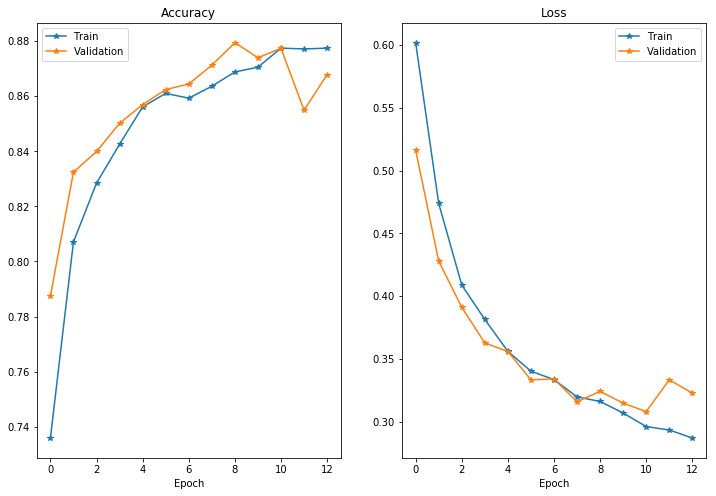

In [18]:
# Setup figure axes
f, ax = plt.subplots(1,2,figsize=[12,8])
# Plot training and validation accuracy
ax[0].plot(model_out_4.history['acc'],'*-')
ax[0].plot(model_out_4.history['val_acc'],'*-')
ax[0].legend(['Train','Validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_title('Accuracy')

# Plot training and validation loss
ax[1].plot(model_out_4.history['loss'],'*-')
ax[1].plot(model_out_4.history['val_loss'],'*-')
ax[1].legend(['Train','Validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss')

Plot the accuracy in the test and validation set, using the model obtained in step 4 and the one using transfer learning.

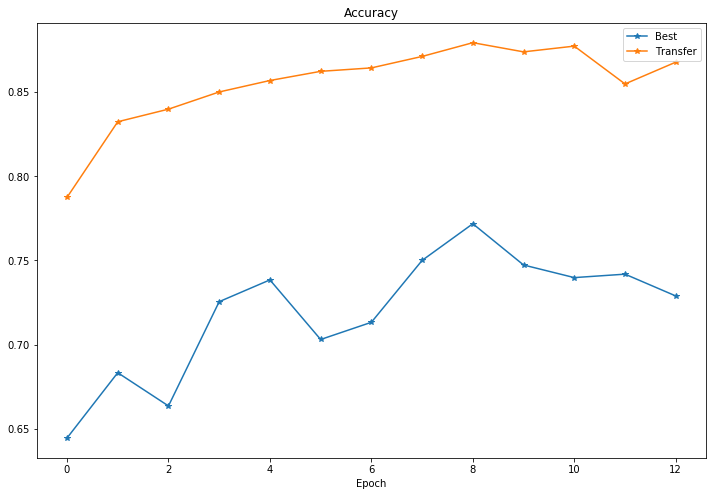

In [19]:
# Setup figure axes
f, ax = plt.subplots(1,1,figsize=[12,8])

# Plot comparison of validation accuracy of model 3 and 4
ax.plot(model_out_3.history['val_acc'],'*-')
ax.plot(model_out_4.history['val_acc'],'*-')
ax.legend(['Best','Transfer'])
ax.set_xlabel('Epoch')
ax.set_title('Accuracy')

Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Explain how you evaluated this.

**Your answer**: By using transfer learning the accuracy is greatly improved. This can be seen by comparing the validation accuracy for the first approach, where the network was built from scratch to the transfer learning approach.

What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer**: ImageNet contains multiple classes with multiple subclasses (ex: Animals-Dogs-Breed-...), while the Dogs vs Cats only contains one class each. ImageNet also only provide the links to the images while the Dogs vs Cats dataset contains the actual images.

Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer**: Since the network we use is trained on ImageNet with consireably more data, the feature space from ImageNet has already been trained to solve similar classification problem. In our case the Dog vs Cats is one kind of subproblem to the ImageNet classification problem.

In which scenario would transfer learning be unsuitable?

**Your answer**: One scenario would be if the pretrained network is trained on data where the type of images are very different from the images that one want to classify. For example a network trained for detecting cancers in medical images would not be much beneficial in our case where we try to identify objects like dogs vs cats.

Save the model to a HDF5 file.

In [20]:
# Save model
model_final.save('Model_4.h5')

### 5.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers.

Tip:
- Always recompile your model after changing anything in it!

In [21]:
# Unfreeze bottom layers
for layer in vgg16.layers:
    layer.trainable = True

Create the callbacks (if any) you would like to use for this training here.

In [22]:
# Setup callbacks
tb=TensorBoard(log_dir='./logs/op5')
estop = EarlyStopping(monitor='val_acc', patience=3)

Compile and train the model.

Tip:
- Even though we not have a decent starting point for the optimization, it's still possible that a bad hyper-parameter choice wrecks the preinitialization. Make sure to use a small learning rate for this step.

In [23]:
# Compile model
model_final.compile(Adam(lr=0.0001/10), loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
model_out_5 = model_final.fit_generator(generator=train_batch, 
                      steps_per_epoch=trainStepEpoch,
                      validation_data=val_batch,
                      validation_steps=valStepEpoch, 
                      epochs=20,
                      callbacks=[tb,estop])


Epoch 1/20
109/109 [==============================] - 95s - loss: 0.1951 - acc: 0.9129 - val_loss: 0.1351 - val_acc: 0.9489
Epoch 2/20
109/109 [==============================] - 91s - loss: 0.0993 - acc: 0.9614 - val_loss: 0.1415 - val_acc: 0.9387
Epoch 3/20
109/109 [==============================] - 91s - loss: 0.0527 - acc: 0.9817 - val_loss: 0.1381 - val_acc: 0.9510
Epoch 4/20
109/109 [==============================] - 91s - loss: 0.0185 - acc: 0.9963 - val_loss: 0.1587 - val_acc: 0.9428
Epoch 5/20
109/109 [==============================] - 91s - loss: 0.0078 - acc: 0.9989 - val_loss: 0.1521 - val_acc: 0.9503
Epoch 6/20
109/109 [==============================] - 91s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.1542 - val_acc: 0.9557
Epoch 7/20
109/109 [==============================] - 90s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1589 - val_acc: 0.9530
Epoch 8/20
109/109 [==============================] - 90s - loss: 6.3876e-04 - acc: 1.0000 - val_loss: 0.1665 - val_acc: 0.9550
Epoc

Plot the accuracy in the test and validation set, using the model trained with freezed layers and the one you just trained.

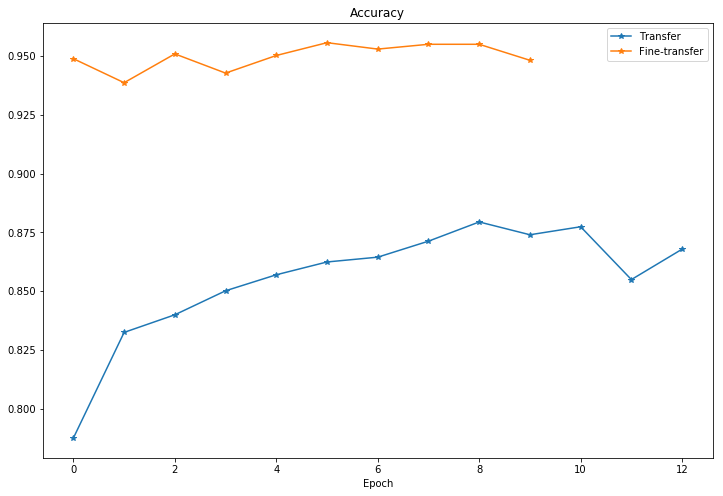

In [24]:
# Plot validation accuracy of model 4 and 5
f, ax = plt.subplots(1,1,figsize=[12,8])
ax.plot(model_out_4.history['val_acc'],'*-')
ax.plot(model_out_5.history['val_acc'],'*-')
ax.legend(['Transfer','Fine-transfer'])
ax.set_xlabel('Epoch')
ax.set_title('Accuracy')

Did the model's performance improve? Why (why not)?

**Your answer**: Yes, the performance improved since we are now able to fine tune the bottom layers to suit our problem even better.

Save the model to a HDF5 file.

In [25]:
# Save model
model_final.save('Model_5.h5')

### 5.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas, and consider comparing them using tensorboard. When you're happy with one architecture, copy it in the cell below and train it here.

Plot the accuracy in the test and validation set, using the model trained in step 5.2 and the one you just trained.

Save the model to a HDF5 file.

## 6. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data generators, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [26]:
# Setup new data generators for final training
test_data_gen = idg(rescale=1./255)
val_data_gen = idg(rescale=1./255)
cls=['dogs','cats']
size_w=128
size_h=128
batchSize=32

trainStepEpoch = 20000//batchSize
valStepEpoch = 5000//batchSize

val_batch=val_data_gen.flow_from_directory('val',
                        target_size=(size_h, size_w),
                        batch_size=batchSize,
                        classes=cls)
train_batch=test_data_gen.flow_from_directory('train',
                        target_size=(size_h, size_w),
                        batch_size=batchSize,
                        classes=cls)


Found 5000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


Create the callbacks you would like to use. This optimization might take a long time, so TensorBoard is advised ;).

In [27]:
# Setup callbacks
tb=TensorBoard(log_dir='./logs/op6')
estop = EarlyStopping(monitor='val_acc', patience=3)

Train your model.

In [29]:
model_finalist = load_model('Model_5.h5')
model_finalist.compile(Adam(lr=0.0001/20), loss='categorical_crossentropy', metrics=['accuracy'])

#= load_model('Model_5.h5')

model_out_6 = model_finalist.fit_generator(generator=train_batch, 
                      steps_per_epoch=trainStepEpoch,
                      validation_data=val_batch,
                      validation_steps=valStepEpoch, 
                      epochs=6,
                      callbacks=[tb,estop])

model_finalist.save('Model_6.h5')

Epoch 1/6
625/625 [==============================] - 501s - loss: 0.1023 - acc: 0.9625 - val_loss: 0.0756 - val_acc: 0.9714
Epoch 2/6
625/625 [==============================] - 502s - loss: 0.0563 - acc: 0.9779 - val_loss: 0.0670 - val_acc: 0.9750
Epoch 3/6
625/625 [==============================] - 501s - loss: 0.0334 - acc: 0.9886 - val_loss: 0.0768 - val_acc: 0.9746
Epoch 4/6
625/625 [==============================] - 500s - loss: 0.0226 - acc: 0.9924 - val_loss: 0.0745 - val_acc: 0.9767
Epoch 5/6
625/625 [==============================] - 498s - loss: 0.0110 - acc: 0.9968 - val_loss: 0.0812 - val_acc: 0.9734
Epoch 6/6
625/625 [==============================] - 495s - loss: 0.0056 - acc: 0.9987 - val_loss: 0.0920 - val_acc: 0.9730


Plot the accuracy on the training and validation set, obtained when you trained this model on the smaller subset of data, and when you trained it now, with the entire dataset.

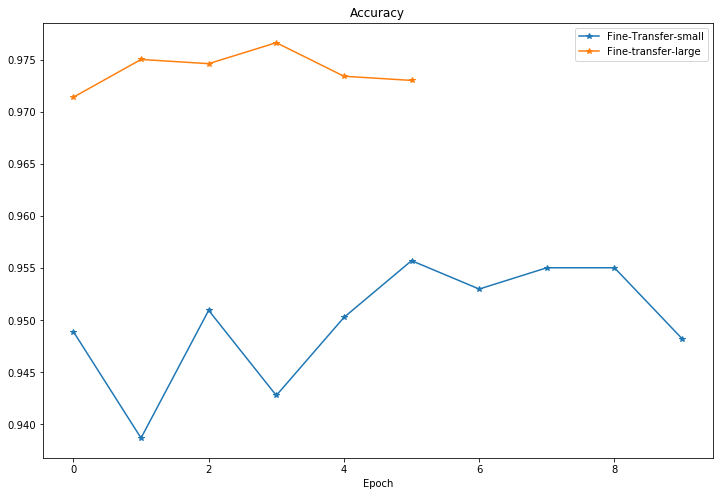

In [30]:
# Plot validation accuracy comparison of model 5 and 6
f, ax = plt.subplots(1,1,figsize=[12,8])
ax.plot(model_out_5.history['val_acc'],'*-')
ax.plot(model_out_6.history['val_acc'],'*-')
ax.legend(['Fine-Transfer-small','Fine-transfer-large'])
ax.set_xlabel('Epoch')
ax.set_title('Accuracy')

What can you conclude from these plots?

**Your answer**: By training on more data we will reduce the varaince as can be seen in the figure. Hence the network will make better predictions. Due to time constraints only 6 epochs were exectuted.

## 7. Evaluation on test set

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labeled, so we can't compute any performance metrics ourselves. Instead, we'll create a .csv file containing the predictions for each sample, and submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

Tip:
- There is a `sample_submission.csv` file available for download in the same place where you downloaded the data from. Take a look at it to better understand what is the expected format here.
- Take a look at the .csv file you generated and make sure it's reasonable before submitting it to Kaggle. You're only allowed a few submissions per day.

Hints:
- The Python module `os` has a `listdir` function, which returns the filenames of all files in a given path.
- If you don't know how to create and write to files with Python, Google can help.
- Keras has a submodule called `preprocessing.image`, with some handy functions (for instance `load_img` and `img_to_array`).
- Alternatively, it's possible to use data generators for this task as well, but be careful about the order of your predictions (if you get a bad score at Kaggle, this is probably why).

In [31]:
# Load final model
myModel_6=load_model('Model_6.h5')
# Paths to list
testlist=os.listdir('test1')
# Sort on image number
lsorted = sorted(testlist,key=lambda x: int(os.path.splitext(x)[0]))
# Initiate labels and id list
label_list=[]
index_list=range(1,len(lsorted)+1)
inc=0
# Iterate through all images, predict label and store in list
for i in lsorted:
    img=load_img('test1/'+i, target_size=(size_h,size_w,3))
    img_vec=img_to_array(img)
    img_vec=np.expand_dims(img_vec,axis=0)
    img_vec=preprocess_input(img_vec)
    predicted=myModel_6.predict(img_vec) #prediction on one picture
    predicted=np.round(predicted)
    
    #print(predicted[0][0])
    label_list.append(int(predicted[0,0]))
    if inc%1000==0:
        print(inc)
    inc=inc+1
print('Done')
# Cerate dataframe with id and labels
d = {'id' : index_list,'label':label_list}
df = pd.DataFrame(d)
# Save to csv file
df.to_csv('submission_final.csv', index=False)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
Done


Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, so submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). Kaggle evaluates your submission according to your log-loss score. What is the score you obtained?

**Your answer**: 2.57802

What was the username you used for this submission?

**Your answer**: gbolmvall